# SDSS Performance Comparison | Hollis McLeod, Elijah Johnson

The following code is the product of the combined efforts of Hollis McLeod and Elijah Johnson for the term project in the Fall 2025 Section #22904 of AST4930 - Special Topics: Machine Learning at the University of Florida. This code is not for viewing, use, analysis, or any other purposes not in compliance with the [University of Florida Honor Code](https://policy.ufl.edu/regulation/4-040/). Violations will be reported accordingly.

## Table of Contents
- [Overview](#Overview)
- [Setup](#Setup)
  - [Installing Packages](#install-and-import-packages)
  - [Defining Paths and Constants](#define-paths-and-constants)
  - [Loading Data and Preliminary Processing](#import-data-and-perform-preliminary-processing)
  - [Saving and Loading Models](#define-methods-for-saving-and-loading-model-information)
- [Set up and Perform Supervised Learning](#supervised-machine-learning)
  - [Set up Training Pipelines per Model](#training-setup)
  - [Set up Analysis Methods per Model](#analysis-setup)
  - [Initial Model Training](#model-training)
  - [Model Optimization](#optimization)
  - [Analysis Products](#model-analysis)
- [Set up and Perform Unsupervised Learning](#unsupervised-machine-learning) (Unused but left behind)
  - [Set up Training Pipelines per Model](#training-setup)
  - [Set up Analysis Methods per Model](#analysis-setup)
  - [Initial Model Training](#model-training)
  - [Model Analysis and Optimization](#model-analysis-and-optimization)

## Overview

This Jupyter notebook defines a method for reading, processing, training machine learning models on, and visualizing results for [SDSS data](https://skyserver.sdss.org/dr19/SearchTools/sql) of the following form.

500,000 rows were downloaded as *SDSS.csv*, although 100,000 rows are planned for use. If computational power permits, however, more will be used for increased rigor of analysis.

**Fields**:
- Identification and standard features of astronomical objects (not used for training)
  - `objid`
  - `ra`
  - `dec`
  - `specobjid`
- Magnitudes
  - `u`
  - `g`
  - `r`
  - `i`
  - `z`
- Color indices (calculated)
  - `u-g`
  - `g-r`
  - `r-i`
  - `i-z`
- `redshift`
- `class`
  - "GALAXY"
  - "QSO" (shorthand for quasar)
  - "STAR"

**SQL Code**:
```
SELECT TOP 500000
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
p.u-p.g as 'u-g', p.g-p.r as 'g-r', p.r-p.i as 'r-i', p.i-p.z as 'i-z',
s.specobjid, s.class, s.z as redshift
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE s.class IN ('GALAXY', 'QSO', 'STAR')
```

## Setup

### Install and Import Packages

In [4]:
# Install if not already installed.
# %pip install pandas
# %pip install numpy
# %pip install scipy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install seaborn
# %pip install tensorflow
# %pip install scikeras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [105]:
# Consolidate all imports together for easy use.
import pandas as pd

import numpy as np

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import tensorflow.keras as keras

# This will allow us to pipeline our NN training... probably going to take a long long time.
from scikeras.wrappers import KerasClassifier

# For capturing subprocess output with GridSearchCV parallelization
from joblib import parallel_backend # TODO: currently unused!

import matplotlib.pyplot as plt

import seaborn as sns

import pickle

import glob

import time

### Define Paths and Constants

In [106]:
# These paths are stored in a dictionary for easy access and non-verbosity
paths = {
    # location of SDSS data
    'data': './data/SDSS.csv',

    # base directories for saved graphs, charts, models
    'supervised_products': './products/supervised/',
    'unsupervised_products': './products/unsupervised/',

    # additional pathing for specific products
    'graphs': 'graphs/',
    'charts': 'charts/',
    'models': 'models/',
    'grid-searches': 'grid-searches/'
}

In [107]:
# The number of rows to be used with the data
NROWS = 100000

# The column names of the features and the class from the dataset
FEATURES = ['u', 'g', 'r', 'i', 'z', 'u-g', 'g-r', 'r-i', 'i-z', 'redshift']
CLASS = 'class'

# The number of CPU cores we want to use for training, when possible. -1 means all that are available.
N_JOBS = -1

# Lists containing the names of the models in use.
SUPERVISED_MODELS = ['kNN', 'DT', 'SVM-C', 'RF-C', 'AdaBoost']
UNSUPERVISED_MODELS = ['k-means', 'GMM', 'DBSCAN', 'NN']

CV = 5
SCALER = StandardScaler()

### Import Data and Perform Preliminary Processing

In [108]:
data = pd.read_csv(paths['data'], nrows=NROWS)
data

,objid,ra,dec,u,g,r,i,z,u-g,g-r,r-i,i-z,specobjid,class,redshift
0,1237668705156530825,263.370025,7.223793,18.08503,16.13823,15.28424,14.93009,14.71180,1.946796,0.853986,0.354156,0.218284,3149144865661544448,STAR,-0.000976
1,1237668705693467044,263.664289,7.488496,20.73099,19.08960,18.26207,17.86547,17.68044,1.641390,0.827530,0.396591,0.185038,3172787664193611776,GALAXY,0.735104
2,1237668705693468328,263.711809,7.529318,19.98693,18.40730,17.72147,17.44062,17.31446,1.579628,0.685833,0.280849,0.126162,3149149538585962496,STAR,-0.000280
3,1237668571475018376,262.378986,6.996502,25.06067,19.90350,18.44531,17.69727,17.27005,5.157169,1.458197,0.748039,0.427219,3172843739286628352,STAR,-0.000059
4,1237671696061236496,263.684828,8.193936,20.79169,19.28190,18.61582,18.31616,18.15825,1.509792,0.666075,0.299660,0.157909,3172804431745935360,STAR,-0.000074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1237666209239269489,255.838908,27.333566,18.55913,16.88940,16.21973,15.95857,15.83906,1.669731,0.669672,0.261165,0.119510,3161585838186326016,STAR,-0.000256
99996,1237662638523220956,240.927307,9.760700,23.87011,21.08361,20.28882,20.15691,20.16212,2.786507,0.794788,0.131912,-0.005213,5493271238775429120,QSO,3.426004
99997,1237651737930499236,239.576144,2.691617,23.77327,23.11989,21.43978,20.39449,19.64420,0.653383,1.680111,1.045284,0.750292,5411089616244856832,GALAXY,0.633541
99998,1237662303525143296,254.194683,26.466377,24.63793,21.74906,19.97466,18.97339,18.56893,2.888876,1.774393,1.001272,0.404459,4706452196270823424,GALAXY,0.496634


Let's check the distribution of classes within our dataset.

In [109]:
count_galaxy = len(data[data['class'] == 'GALAXY'])
count_qso = len(data[data['class'] == 'QSO'])
count_star = len(data[data['class'] == 'STAR'])
count_galaxy, count_qso, count_star

(57487, 9936, 32577)

Yikes. We'd like to get a better distribution than this. Let's create a filter so that we can use the `pandas` `head()` function to get a specific number of rows for each class.

In [110]:
classes = np.unique(data['class'])
ROWS_PER_CLASS = int(np.floor(NROWS / len(classes)))
classes, ROWS_PER_CLASS

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), 33333)

We'll do 33333, 33333, and 33334. Close enough.

In [111]:

# Load all the data to make sure we get enough for each class
data_500k = pd.read_csv(paths['data'])

# Filter the data by class 
galaxy_filtered = data_500k[data_500k['class'] == 'GALAXY']
qso_filtered = data_500k[data_500k['class'] == 'QSO']
star_filtered = data_500k[data_500k['class'] == 'STAR']

del data_500k

# Get the specified number of values and concatenate their results into a single dataframe, resetting their indices
data = pd.concat([galaxy_filtered.head(ROWS_PER_CLASS), qso_filtered.head(ROWS_PER_CLASS), star_filtered.head(ROWS_PER_CLASS + 1)], ignore_index=True)
del galaxy_filtered, qso_filtered, star_filtered
data

,objid,ra,dec,u,g,r,i,z,u-g,g-r,r-i,i-z,specobjid,class,redshift
0,1237668705693467044,263.664289,7.488496,20.73099,19.08960,18.26207,17.86547,17.68044,1.641390,0.827530,0.396591,0.185038,3172787664193611776,GALAXY,0.735104
1,1237648675071132414,248.728854,0.756609,18.99152,17.47100,16.62550,16.10415,15.79107,1.520521,0.845495,0.521349,0.313081,391939364575275008,GALAXY,0.090854
2,1237648705142456417,248.463236,0.499930,21.65282,19.12659,17.71856,17.15539,16.80021,2.526228,1.408033,0.563171,0.355175,391944312377600000,GALAXY,0.209309
3,1237668707298771498,253.018612,13.770405,19.82589,18.95517,18.59212,18.45801,18.47598,0.870722,0.363050,0.134111,-0.017973,3171783535384094720,GALAXY,0.760823
4,1237655550743871918,247.750760,0.255930,21.05925,18.34572,17.23641,16.77036,16.32670,2.713522,1.109316,0.466053,0.443657,410001047604455424,GALAXY,0.113284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1237667782857261088,238.621872,13.986409,18.32163,17.34970,16.97015,16.82816,16.77014,0.971930,0.379545,0.141989,0.058025,5517169124558788608,STAR,0.000093
99996,1237671937119027887,260.909855,32.968275,22.38795,20.59959,20.29095,20.20671,20.18482,1.788359,0.308649,0.084236,0.021891,5627508964411594752,STAR,-0.000911
99997,1237655473436165517,256.566709,31.598930,25.02460,22.33547,21.80062,21.35446,20.70464,2.689135,0.534853,0.446157,0.649820,5626306098959243264,STAR,-0.000811
99998,1237662223553462645,243.506664,22.235279,19.88461,18.94801,18.56742,18.40804,18.37111,0.936598,0.380596,0.159372,0.036932,4422638552489416704,STAR,-0.000339


Let's check again.

In [112]:
count_galaxy = len(data[data['class'] == 'GALAXY'])
count_qso = len(data[data['class'] == 'QSO'])
count_star = len(data[data['class'] == 'STAR'])
count_galaxy, count_qso, count_star

(33333, 33333, 33334)

Great! Let's split up the data and get moving!

In [113]:
# Separate into X and Y
X = data[FEATURES].values
Y = data[CLASS]

CLASSES = np.unique(Y)

print(f'SHAPES:\n  -{X.shape}\n  -{Y.shape}')
print(f'CLASSES: {CLASSES}')

SHAPES:
  -(100000, 10)
  -(100000,)
CLASSES: ['GALAXY' 'QSO' 'STAR']


In [114]:
# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

In [161]:
# Perform PCA for 2 dimensions for data visualization
def show_with_2d_pca(x, plot_arrows=True, save=True):
    x_scaled = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)

    x_pca = pca.fit_transform(x_scaled)
    x_inverse = pca.inverse_transform(x_pca)

    plt.figure(figsize=(7,7))
    plt.plot(x_pca[:, 0], x_pca[:, 1], "bo", alpha=0.5)
    # plt.axis TODO:???
    plt.xlabel("$PC_1$", fontsize=18)
    plt.ylabel("$PC_2$", fontsize=18, rotation=0)

    if plot_arrows: 
        # Plotting PC1
        plt.arrow(0, 0, pca.components_[0, 0], pca.components_[0, 1], width=0.1, color='r', zorder=10)

        # Plotting PC2
        plt.arrow(0, 0, pca.components_[1, 0], pca.components_[1, 1], width=0.1, color='g', zorder=10)

    plt.grid(True)
    if save: plt.savefig(f'./products/SDSS(rows={NROWS})_PCA_2D.png')
    plt.show()


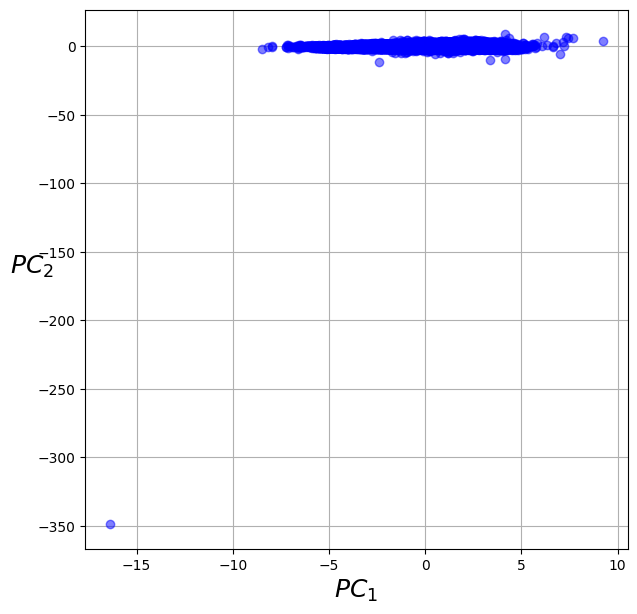

In [16]:
show_with_2d_pca(X, plot_arrows=False)

Clearly, the PCAed data won't provide a good visualization due to apparent overlap. Lets try plotting the kNN's two most important features (redshift and z magnitude).

In [162]:
# Plot the data on feature vs feature axes for data visualization - enter features as strings
def plot_2d_data(feature1, feature2, save=True):
    data_g = data[data['class'] == 'GALAXY']
    data_s = data[data['class'] == 'STAR']
    data_q = data[data['class'] == 'QSO']
    
    X1g = data_g[feature1].values
    X1s = data_s[feature1].values
    X1q = data_q[feature1].values
    
    X2g = data_g[feature2].values
    X2s = data_s[feature2].values
    X2q = data_q[feature2].values
    
    
    plt.figure(figsize=(7,7))
    plt.scatter(X1q, X2q, edgecolors='b', label='Quasars', facecolors='none')
    plt.scatter(X1g, X2g, edgecolors='r', label='Galaxies', facecolors='none', alpha=0.5)
    plt.scatter(X1s, X2s, edgecolors='g', label='Stars', facecolors='none', alpha=0.5)

    plt.legend()
    plt.xlabel(feature1, fontsize=18)
    plt.ylabel(feature2, fontsize=18)
    plt.title(feature1 + ' vs. ' + feature2)

    plt.grid(True)
    if save: plt.savefig(f'./products/data2d.png')
    plt.show()

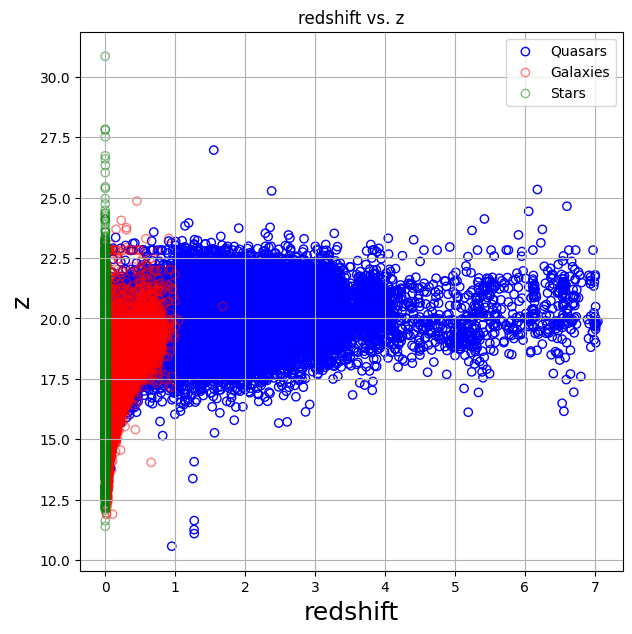

In [18]:
plot_2d_data('redshift', 'z')

### Define Methods for Saving and Loading Model Information

In [115]:
# Helper function to extract the parameters of a model into a meaningful string for titles and filenames.
def get_model_and_model_str(gs, model_name=None):
    feature_str = ''
    model = None
    match model_name:
        case 'kNN':
            model = gs.best_estimator_[1]
            n_neighbors = gs.best_params_['kNN__n_neighbors']
            algo = gs.best_params_['kNN__algorithm']
            feature_str = f'(k={n_neighbors})(algorithm={algo})'
        case 'DT':
            model = gs.best_estimator_[0]
            m_d = gs.best_params_['DT__max_depth']
            crit = gs.best_params_['DT__criterion']
            feature_str = f'(max_depth={m_d})(criterion={crit})'
        case 'SVM-C':
            model = gs.best_estimator_[1]
            c = gs.best_params_['SVM-C__C']
            gamma = gs.best_params_['SVM-C__gamma']
            feature_str = f'(C={c})(gamma={gamma})'
        case 'RF-C':
            model = gs.best_estimator_[0]
            n_est = gs.best_params_['RF-C__n_estimators']
            feature_str = f'(n_estimators={n_est})'
        case 'AdaBoost':
            model = gs.best_estimator_[0]
            n_est = gs.best_params_['AdaBoost__n_estimators']
            learn_rate = gs.best_params_['AdaBoost__learning_rate']
            feature_str = f'(n_estimators={n_est})(learning_rate={learn_rate})'
        case 'k-means':
            model = gs.best_estimator_[1]
            n_clusters = gs.best_params_['k-means__n_clusters']
            n_init = gs.best_params_['k-means__n_init']
            feature_str = f'(n_clusters={n_clusters})(n_init={n_init})'
        case 'GMM':
            model = gs.best_estimator_[1]
            n_comp = gs.best_params_['GMM__n_components']
            n_init = gs.best_params_['GMM__n_init']
            feature_str = f'(n_components={n_comp})(n_init={n_init})'
        case 'DBSCAN':
            model = gs.best_estimator_[1]
            eps = gs.best_params_['DBSCAN__eps']
            min_samp = gs.best_params_['DBSCAN__min_samples']
            feature_str = f'(eps={eps})(min_samples={min_samp})'
        case 'NN':
            model = gs.best_estimator_[1]
            b_sz = gs.best_params_['NN__batch_size']
            epochs = gs.best_params_['NN__epochs']
            a_fn = gs.best_params_['NN__activation_function']
            l_rt = gs.best_params_['NN__learning_rate']
            opt = gs.best_params_['NN__optimizer']
            feature_str = f'(batch_size={b_sz})(epochs={epochs})(activation_function={a_fn})(learning_rate={l_rt})(optimizer={opt})'
        case _:
            raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to one of the models listed in `SUPERVISED_MODELS` or `UNSUPERVISED_MODELS` at the top of this document.')
        
    return model, model_name+feature_str

In [116]:
# Determine the location for where a specific model is stored.
def getloc_for_pkl(model_name, isModel=True):
    loc = paths['supervised_products'] if model_name in SUPERVISED_MODELS \
                else paths['unsupervised_products'] if model_name in UNSUPERVISED_MODELS \
                else False
    if not loc: raise ValueError('The \'model_name\' parameter must be equal to one of the models in use. Please see SUPERVISED_MODELS and UNSUPERVISED_MODELS.')
    loc += paths['models'] if isModel else paths['grid-searches']
    return loc

# Save the model to a specific location with its features in its name.
def save_model(model, model_name, feature_str):
    loc = getloc_for_pkl(model_name)
    with open(f'{loc}{feature_str}.pkl', 'wb') as f:
        pickle.dump(model, f)

# Get the feature string of a filename.
def get_feature_str_from_filename(f):
    title = f.title()
    last_backslash_index = title.rfind('\\')
    filename = title[last_backslash_index + 1:]
    last_period_index = filename.rfind('.')
    feature_str = filename[:last_period_index]
    return feature_str

# Get a model from a specific location or by name. If by name, return the first result.
def load_model(pkl_name=None, model_name=None, return_feature_str=False):
    if model_name: loc = getloc_for_pkl(model_name)

    # Get the name of the .pkl file based on which parameter was provided.
    filename = glob.glob(f'{loc}{model_name}*.pkl' if model_name else pkl_name)[0]

    with open(filename, 'rb') as f: 
        return pickle.load(f) if not return_feature_str else pickle.load(f), get_feature_str_from_filename(filename)

In [117]:
# Save an entire grid search to a specific location
def save_grid_search(gs, model_name):
    model, feature_str = get_model_and_model_str(gs, model_name)
    loc = getloc_for_pkl(model_name, isModel=False)
    with open(f'{loc}GS_{feature_str}.pkl', 'wb') as f:
        pickle.dump(gs, f)

# Get a grid search from a specific location or by name. If by name, return the first result.
def load_grid_search(pkl_name=None, model_name=None, return_feature_str=False):
    if model_name: loc = getloc_for_pkl(model_name, isModel=False)
    
    # Get the name of the .pkl file based on which parameter was provided
    filename = glob.glob(f'{loc}GS_{model_name}*.pkl' if model_name else pkl_name)[0]
    print(f"Loading file {filename} for {('model_name=' + model_name) if model_name else ('pkl_name=' + pkl_name)}")

    with open(filename, 'rb') as f:
        return (pickle.load(f)) if not return_feature_str else (pickle.load(f), get_feature_str_from_filename(filename))

## Supervised Machine Learning

This section contains training, optimization, testing, and creation of products for the following supervised machine learning algorithms:

- k-Nearest Neighbors (kNN)
- Decision Tree (DT)
- Support Vector Machine Classifier (SVM-C)
- Random Forest Classifier (RF-C)
- Adaptive Boosting (AdaBoost) with Base DT
- Neural Network (NN) with default=2 layers of default=200 nodes

### Training Setup

Define functions to create `Pipeline`s and parameter grids for each model, for experimentation and cleanliness. The default values for the hyperparameters may be tweaked and changed, since it is not necessary to risk overcompensating and wasting time for being unsure about what is needed. There will be sufficient evidence provided that the results of these parameters are indeed useful and meaningful, but the code required to determine sufficient ranges of hyperparameters and their respective outputs may not be included in the submission of this notebook.

Models requiring feature scaling include a scaler in their pipeline.

In [118]:
# Produce a pipeline and parameter grid for kNN
def create_knn_for_grid_search(n_neighbors=np.arange(10)+1, algos=['auto']):
    pipe = Pipeline([
        ('scaler', SCALER), # kNN requires feature scaling!
        ('kNN', KNeighborsClassifier())
    ])

    param_grid = {
        'kNN__n_neighbors': n_neighbors,
        'kNN__algorithm': algos
    }

    return pipe, param_grid

In [119]:
# Produce a pipeline and parameter grid for DT
def create_dt_for_grid_search(max_depth=np.arange(10)+1, criterion=['gini', 'entropy']):
    pipe = Pipeline([
        ('DT', DecisionTreeClassifier(random_state=0))
    ])

    param_grid = {
        'DT__max_depth': max_depth,
        'DT__criterion': criterion
    }

    return pipe, param_grid

In [120]:
# Produce a pipeline and parameter grid for SVM-C
def create_svmc_for_grid_search(C=np.logspace(3, 6, num=4), gamma=np.logspace(-5, 0, num=4)):
    pipe = Pipeline([
        ('scaler', SCALER), # SVM requires feature scaling!
        ('SVM-C', SVC(kernel='rbf', random_state=0))
    ])

    param_grid = {
        'SVM-C__C': C,
        'SVM-C__gamma': gamma
    }

    return pipe, param_grid

In [121]:
# Produce a pipeline and parameter grid for RF-C
def create_rfc_for_grid_search(n_estimators=[100, 500, 1000, 5000]):
    pipe = Pipeline([
        ('RF-C', RandomForestClassifier(oob_score=True, random_state=0))
    ])

    param_grid = {
        'RF-C__n_estimators': n_estimators
    }

    return pipe, param_grid

In [122]:
# Produce a pipeline and parameter grid for AdaBoost with Base DT.
def create_adaboost_for_grid_search(n_estimators=[10, 50, 100, 200], learning_rate=[0.001, 0.01, 0.1, 1.0], max_depth=1, criterion='gini'):
    # Per Worksheet 5, we want a poor base estimator for AdaBoost, so we default to max_depth=1 and criterion='gini.
    pipe = Pipeline([
        ('AdaBoost', AdaBoostClassifier(
            random_state=0,
            estimator=DecisionTreeClassifier(
                max_depth=max_depth,
                criterion=criterion)))
    ])

    param_grid = {
        'AdaBoost__n_estimators': n_estimators,
        'AdaBoost__learning_rate': learning_rate
    }

    return pipe, param_grid

In [123]:
# DEFUNCT
# Oh boy. Produce a setup just for training neural networks. Yikes. This is adapted from the Module 7 Neural Networks Worksheet.
def create_nn_for_grid_search(batch_size=[32, 64], epochs=[50, 100, 150], activation_function='relu', hidden_layers=2, nodes_per_hidden_layer=200, learning_rate=[0.001, 0.01], optimizer=['adam', 'sgd'], x_tr=X_train, y_tr=Y_train, metrics=['accuracy'], loss_fn='sparse_categorical_crossentropy'):
    x_tr_flat = np.array([obj.flatten() for obj in x_tr])
    y_tr_flat = y_tr.flatten()

    print(x_tr_flat.shape)
    print(y_tr_flat.shape)

    # Yuck. Define a function that builds the model for the grid search. Yuck yuck yuck ugly ugly ugly ughhhhh
    def build_model(hidden_layers=2, nodes_per_hidden_layer=200, activation_function='relu', learning_rate=0.001, optimizer='adam'):
        m = keras.models.Sequential()

        # The input layer needs to have the number of features as its size.
        m.add(keras.layers.Input(shape=(x_tr_flat.shape[1])))

        # Add the designated amount of hidden layers with the designated activation function and number of neurons.
        for _ in range(hidden_layers):
            m.add(keras.layers.Dense(nodes_per_hidden_layer, activation=activation_function))

        # Add an output layer having "softmax" activation function.
        m.add(keras.layers.Dense(np.unique(y_tr_flat).shape[0], activation='softmax'))

        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = keras.optimizers.SGD(learning_rate=learning_rate)
        else: opt = optimizer

        m.summary()

        # Compile the model with the designated optimizer.
        m.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
        return m

    # NOW we can make the Grid Search pipeline! Awesome!!!! I'm so excited yay!!!!
    pipe = Pipeline([
        ('scaler', SCALER),
        ('NN', KerasClassifier(model=build_model, verbose=1))
    ])

    param_grid = {
        'NN__batch_size': batch_size,
        'NN__epochs': epochs,
        'NN__activation_function': activation_function,
        'NN__learning_rate': learning_rate,
        'NN__optimizer': optimizer
    }

    return pipe, param_grid

Define a function to train models using a grid search with `CV` folds and `N_JOBS` cpu cores (defined above). This model takes the outputs of the functions above that produce pipelines and parameter grids for each type of supervised algorithm. This way, creating and training a model can be accomplished in just two lines! Given the volume of training and trial and error that will (likely) be needed, streamlining this process is essential for reducing headache. 

In [124]:
# Custom scorer for clustering.
def silhouette_scorer(model, x):
    labels = model.predict(X)
    return silhouette_score(X, labels)

# Train a grid search model on a pipeline and a parameter grid, printing the best results and returning the grid search.
def get_grid_search_results(pipe, param_grid, x_train=X_train, x_test=X_test, y_train=Y_train, y_test=Y_test, n_jobs=N_JOBS, cv=CV, r_t_s=True, verbose=3, save_model_to_pkl=True, save_gs_to_pkl=True, unsupervised=False):
    scorer = silhouette_scorer if unsupervised else None
    
    grid_search = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
        return_train_score=r_t_s,
        scoring=scorer
    )

    tstart = time.time()

    if unsupervised: grid_search.fit(x_train)
    else: grid_search.fit(x_train, y_train)

    gs_time = time.time() - tstart

    if save_model_to_pkl:
        steps = list(pipe.named_steps.keys())
        m_name = steps[1] if steps[0] == 'scaler' else steps[0]
        m, ftr_str = get_model_and_model_str(grid_search, m_name)
        save_model(m, m_name, ftr_str)

    if save_gs_to_pkl:
        steps = list(pipe.named_steps.keys())
        m_name = steps[1] if steps[0] == 'scaler' else steps[0]
        save_grid_search(grid_search, m_name)

    print(f'Best Model: {grid_search.best_estimator_}')
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Best CV Score: {grid_search.best_score_}')

    if unsupervised: print(f'Test Silhouette Score: {silhouette_score(x_test, grid_search.predict(x_test))}')
    else: print(f'Test Score: {grid_search.score(x_test, y_test)}')

    print(f"Mean Fit Time: {np.mean(grid_search.cv_results_['mean_fit_time'])}s") #TODO: look into creating a way to track every single fit time? this one sucks
    print(f'Time to complete grid search: {gs_time}s = {gs_time / 60} minutes')
    return grid_search, gs_time

### Analysis Setup

#### General

For supervised models, we can create a plot of feature importances and a confusion matrix for each model. This way we can determine, on average, which features are the most important across the board and how well each model is determining class assignments.

In [125]:
# Make a plot of feature importance using code adapted from the module 3 worksheet.
def plot_feature_importances_from_supervised_grid_search(gs, model_name=None, x_tr=X_train, x_te=X_test, y_tr=Y_train, y_te=Y_test, save=True, n_repeats=10):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    # Gather information about the model
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)

    # Get actual feature importances
    model.fit(x_tr, y_tr)
    r = permutation_importance(model, x_te, y_te, n_repeats=n_repeats, random_state=0)

    n_features = len(FEATURES)
    plt.barh(np.arange(n_features), r.importances_mean, align='center')
    plt.yticks(np.arange(n_features), FEATURES)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)

    # Add a title and save the plot
    plt.title(f'{model_name} SDSS Feature Importances {feature_str}')
    plt.tight_layout()
    if save: plt.savefig(paths['supervised_products'] + paths['charts'] + f'Feature_Importances_{feature_str}.png')
    plt.show()


In [159]:
# Make a confusion matrix using the supervised grid_search's best estimator. Adapted from module 2 worksheet.
def confusion_matrix_from_grid_search(gs, model_name=None, x_te=X_test, y_te=Y_test, save=True):
    if model_name is None: raise ValueError('The \'model_name\' parameter cannot be unspecified. Please set \'model_name\' equal to \'kNN\', \'DT\', \'SVM-C\', \'RF-C\', or \'AdaBoost\'.')
    
    # Get information about the model
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)
    prediction = gs.best_estimator_.predict(x_te)

    cm = confusion_matrix(y_true=y_te, y_pred=prediction)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix for {feature_str}')
    disp.figure_.tight_layout()
    if save: disp.figure_.savefig(paths['supervised_products'] + paths['charts'] + f'Confusion_Matrix_{feature_str}.png')
    plt.show()

In [127]:
# Produce a heatmap for models having two hyperparameters.
def heatmap_from_gs(gs, model_name=None, save=True):
    model, feature_str = get_model_and_model_str(gs, model_name=model_name)
    results = pd.DataFrame(gs.cv_results_)

    # Create the grid
    keys = list(gs.param_grid.keys())
    axes = None
    if len(keys) == 2:
        axes = [gs.param_grid[keys[0]], gs.param_grid[keys[1]]]
    elif len(keys) == 3:
        keys = keys[1:]
        axes = [gs.param_grid[keys[0]], gs.param_grid[keys[1]]]
    else: raise ValueError("function heatmap_from_gs() only works with 2-dimensional parameter grids. Please use a model with only two hyperparameters.")
    len_ax1 = len(axes[0])
    len_ax2 = len(axes[1])
    scores = np.array(results.mean_test_score).reshape(len_ax1, len_ax2).T

    # Create the actual heatmap, labeled properly with scores included
    ax = sns.heatmap(scores, annot=True, fmt=".2f",
                     xticklabels=np.array(axes[0]).astype(str),
                     yticklabels=np.array(axes[1]).astype(str))
    ax.set_xlabel(keys[0])
    ax.set_ylabel(keys[1])
    ax.set_title(f'Heatmap for {feature_str}')
    ax.collections[0].colorbar.set_label('mean_test_score')
    if save: ax.figure.savefig(paths['supervised_products' if model_name in SUPERVISED_MODELS else 'unsupervised_products'] + paths['charts'] + f'Heatmap_{feature_str}.png')
    ax.figure.show()

#### kNN

For kNN models, we can create a plot of mean squared error against each attempted value for `n_neighbors` to visually understand why the best model was chosen.

In [128]:
# Plot the test score as a function of n_neighbors. Adapted from module 4 worksheet.
def plot_test_score_vs_k_knn(gs_knn, save=True):
    model, feature_str = get_model_and_model_str(gs_knn, model_name='kNN')
    results = gs_knn.cv_results_['mean_test_score']
    n_neighbors = len(gs_knn.cv_results_['mean_test_score'])
    plt.scatter(np.arange(n_neighbors)+1, results)
    plt.xlabel('n_neighbors')
    plt.ylabel('Test Score')
    plt.title(f'kNN Test Score as n_neighbors approaches {n_neighbors}')
    plt.xticks(np.arange(len(results)) + 1)
    plt.tight_layout()
    if save: plt.savefig(paths['supervised_products'] + paths['graphs'] + f'Test_Score_vs_k_{feature_str}.png')
    plt.show()

#### DT

For decision trees, we can optionally create a visual of the tree itself.

In [129]:
# Print a visual tree of the best estimator
# TODO: may not be useful LOL
def plot_grid_search_DT(gs_dt):
    plot_tree(gs_dt.best_estimator_[0], feature_names=FEATURES, class_names=CLASSES)

#### SVM Classifier

There are no model-specific analysis products for the Support Vector Machine Classifier.

#### RF Classifier

There are no model-specific analysis products for the Random Forest Classifier.

#### AdaBoost Classifier with Base DT

There are no model-specific analysis products for the AdaBoost Classifier with Base DT.

### Model Training

This training run was performed on HiperGator, and the resulting `grid_search` objects were saved and loaded locally for analysis and improved training runs.

In [163]:
# RUN ON HIPERGATOR
# pipe_knn, pg_knn = create_knn_for_grid_search()
# gs_knn = get_grid_search_results(pipe_knn, pg_knn)

In [164]:
# RUN ON HIPERGATOR
# pipe_dt, pg_dt = create_dt_for_grid_search()
# gs_dt = get_grid_search_results(pipe_dt, pg_dt)

In [165]:
# RUN ON HIPERGATOR
# pipe_svmc, pg_svmc = create_svmc_for_grid_search()
# gs_svmc = get_grid_search_results(pipe_svmc, pg_svmc)

In [166]:
# RUN ON HIPERGATOR
# pipe_rfc, pg_rfc = create_rfc_for_grid_search()
# gs_rfc = get_grid_search_results(pipe_rfc, pg_rfc)

In [167]:
# RUN ON HIPERGATOR
# pipe_adaboost, pg_adaboost = create_adaboost_for_grid_search()
# gs_adaboost = get_grid_search_results(pipe_adaboost, pg_adaboost)

### Optimization

#### kNN

Loading file ./products/supervised/grid-searches\GS_kNN(k=3)(algorithm=auto).pkl for model_name=kNN


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\A

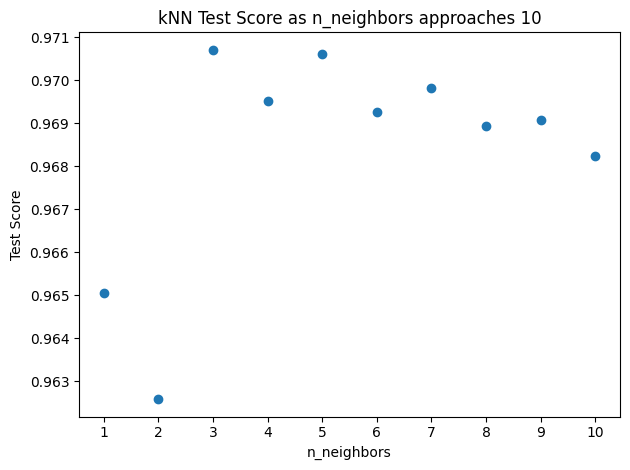

In [130]:
# DOWNLOADED FROM HIPERGATOR
hg_gs_knn, hg_knn_ftr_str = load_grid_search(model_name='kNN', return_feature_str=True)
plot_test_score_vs_k_knn(hg_gs_knn, save=False)

Awesome! We got what appears to be the best kNN model. No further training is needed, when examining that the .pkl file name indicates $\text{k}=3$ for this `grid_search`.

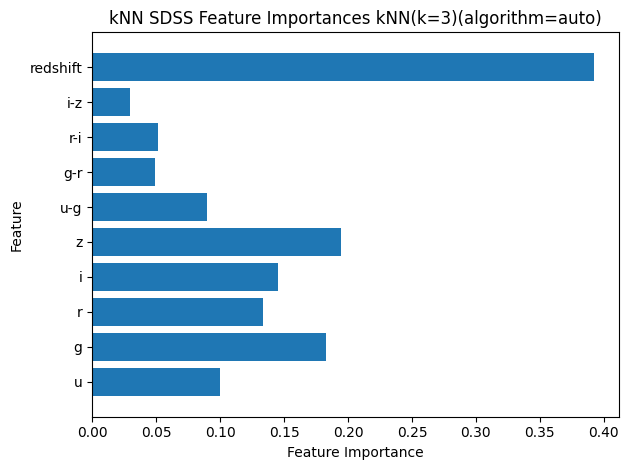

In [131]:
# Plot feature importances from best kNN model to decide 2 features to use in data visualization
plot_feature_importances_from_supervised_grid_search(hg_gs_knn, model_name='kNN', save=False)

#### DT

In [132]:
# DOWNLOADED FROM HIPERGATOR
hg_gs_dt, hg_dt_ftr_str = load_grid_search(model_name='DT', return_feature_str=True)
hg_gs_dt.param_grid

Loading file ./products/supervised/grid-searches\GS_DT(max_depth=8)(criterion=entropy).pkl for model_name=DT


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppDa

{'DT__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'DT__criterion': ['gini', 'entropy']}

There isn't much to do here, except to see that the parameter space has lent itself to an effective range of depths, and that the `grid_search` was able to find the best Decision Tree. Cool!

#### SVM-C

Loading file ./products/supervised/grid-searches\GS_SVM-C(C=1000.0)(gamma=0.021544346900318843).pkl for pkl_name=./products/supervised/grid-searches/*SVM-C(C=1000.0)(gamma=0.02*.pkl


C:\Users\Eli\AppData\Local\Temp\ipykernel_20896\1355619233.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


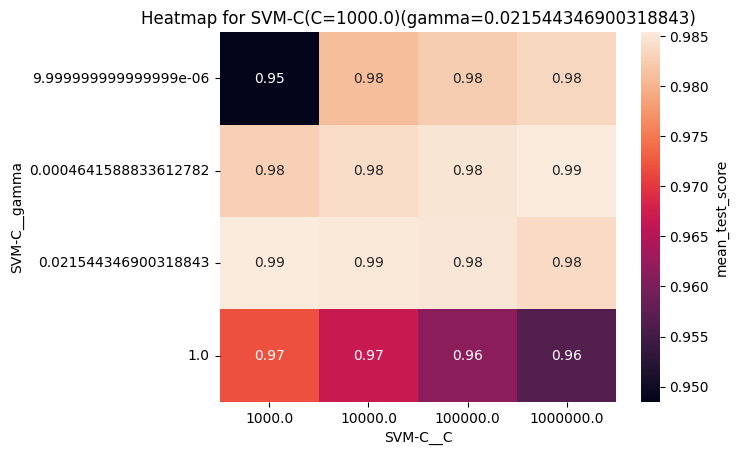

In [35]:
# DOWNLOADED FROM HIPERGATOR
path_svmc = paths['supervised_products'] + paths['grid-searches'] + '*SVM-C(C=1000.0)(gamma=0.02*.pkl'
hg_gs_svmc = load_grid_search(pkl_name=path_svmc)
heatmap_from_gs(hg_gs_svmc, 'SVM-C')

Given the above, it seems we can attempt to reduce our range for C to [$100, 1000, 10000$], and that the value of `SVM-C__gamma` is sitting around [$0.001, 0.01, 0.1$]. Let's run it again, also on HiperGator. 

This one easily took the longest to train. On a HiperGator session with 8 cores and 48 GB of memory, it took nearly an hour by itself. We messed up the first run due to some mislabeled code too, so we had to run it twice to get the first `grid_search` saved to a pickle file. Quite frustrating!

In [36]:
del hg_gs_svmc

In [37]:
# RUN ON HIPERGATOR
# pipe_svmc2, pg_svmc2 = create_svmc_for_grid_search(C=[100, 1000, 10000], gamma=[0.001, 0.01, 0.1])
# gs_svmc2 = get_grid_search_results(pipe=pipe_svmc2, param_grid=pg_svmc2)

Loading file ./products/supervised/grid-searches\GS_SVM-C(C=10000)(gamma=0.01).pkl for pkl_name=./products/supervised/grid-searches/GS_SVM-C(C=10000)*.pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Pack

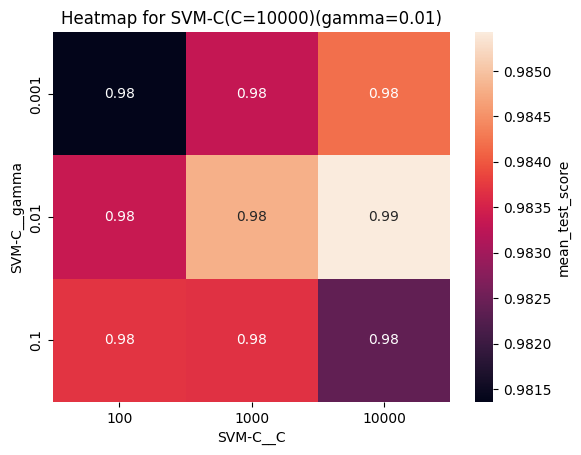

In [38]:
# DOWNLOADED FROM HIPERGATOR
path_svmc2 = paths['supervised_products'] + paths['grid-searches'] + 'GS_SVM-C(C=10000)*.pkl'
hg_gs_svmc2 = load_grid_search(pkl_name=path_svmc2)
heatmap_from_gs(hg_gs_svmc2, 'SVM-C')

Still looks like it could use some improvement... lets try another range.

In [39]:
del hg_gs_svmc2

In [40]:
# RUN ON HIPERGATOR
# pipe_svmc3, pg_svmc3 = create_svmc_for_grid_search(C=[10000, 100000, 1000000], gamma=[0.1, 0.01, 0.001])
# gs_svmc3 = get_grid_search_results(pipe=pipe_svmc3, param_grid=pg_svmc3)

Loading file ./products/supervised/grid-searches\GS_SVM-C(C=100000)(gamma=0.01).pkl for pkl_name=./products/supervised/grid-searches/GS_SVM-C(C=100000*


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Pack

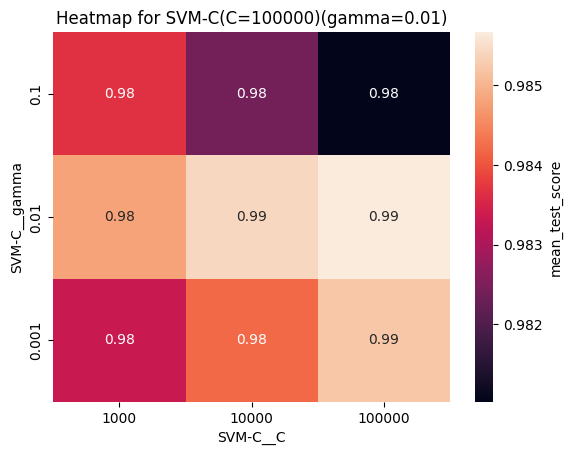

In [133]:
# DOWNLOADED FROM HIPERGATOR
path_svmc3 = paths['supervised_products'] + paths['grid-searches'] + 'GS_SVM-C(C=100000*'
hg_gs_svmc3 = load_grid_search(pkl_name=path_svmc3)
heatmap_from_gs(hg_gs_svmc3, 'SVM-C')

We've definitely identified the best value for gamma, and it seems increasing C from here is helping. However, the accuracy is pretty solid. We don't need any more HiperGator time with this. Cool!

#### RF-C

In [41]:
# DOWNLOADED FROM HIPERGATOR
path_rfc = paths['supervised_products'] + paths['grid-searches'] + 'GS_RF-C(n_estimators=500).pkl'
hg_gs_rfc, hg_rfc_ftr_str = load_grid_search(model_name='RF-C', return_feature_str=True)

Loading file ./products/supervised/grid-searches\GS_RF-C(n_estimators=500).pkl for model_name=RF-C


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\U

In [42]:
print(hg_gs_rfc.best_params_)

{'RF-C__n_estimators': 500}


In this case, notably, $500$ estimators was the ideal amount. Let's see if we can't get that number smaller. We're going to drastically reduce the range and train it with HiperGator.

In [43]:
del hg_gs_rfc, hg_rfc_ftr_str

In [44]:
# RUN ON HIPERGATOR
# pipe_rfc2, pg_rfc2 = create_rfc_for_grid_search(n_estimators=[475, 500, 525])
# gs_rfc2 = get_grid_search_results(pipe=pipe_rfc2, param_grid=pg_rfc2)

In [134]:
# DOWNLOADED FROM HIPERGATOR
path_rfc2 = paths['supervised_products'] + paths['grid-searches'] + 'GS_RF-C(*)_2.pkl'
hg_gs_rfc2 = load_grid_search(pkl_name=path_rfc2)

C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\U

Loading file ./products/supervised/grid-searches\GS_RF-C(n_estimators=500)_2.pkl for pkl_name=./products/supervised/grid-searches/GS_RF-C(*)_2.pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:
print(hg_gs_rfc2.best_params_)

{'RF-C__n_estimators': 500}


Interesting. Must've been a pretty good choice! Let's try just a little more to further narrow the selection.

In [47]:
# RUN ON HIPERGATOR
# pipe_rfc3, pg_rfc3 = create_rfc_for_grid_search(n_estimators=[495, 500, 505])
# gs_rfc3 = get_grid_search_results(pipe=pipe_rfc3, param_grid=pg_rfc3)

In [136]:
# DOWNLOADED FROM HIPERGATOR
path_rfc3 = paths['supervised_products'] + paths['grid-searches'] + 'GS_RF-C(*)_*.pkl'
hg_gs_rfc3 = load_grid_search(pkl_name=path_rfc3)

Loading file ./products/supervised/grid-searches\GS_RF-C(n_estimators=500)_2.pkl for pkl_name=./products/supervised/grid-searches/GS_RF-C(*)_*.pkl


In [137]:
print(hg_gs_rfc3.best_params_)

{'RF-C__n_estimators': 500}


#### AdaBoost

Loading file ./products/supervised/grid-searches/GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl for pkl_name=./products/supervised/grid-searches/GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users

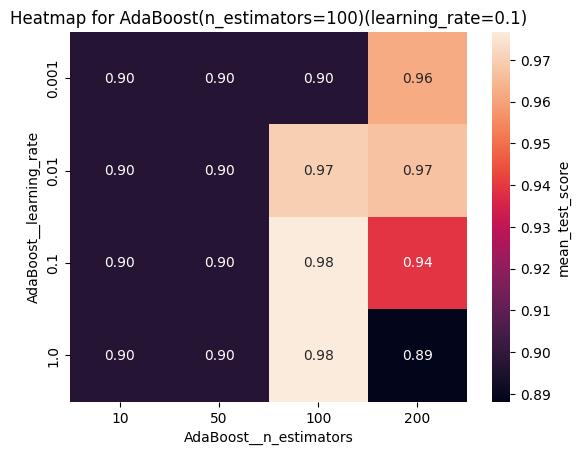

In [94]:
# DOWNLOADED FROM HIPERGATOR
path_ada = paths['supervised_products'] + paths['grid-searches'] + 'GS_AdaBoost(n_estimators=100)(learning_rate=0.1).pkl'
hg_gs_adaboost = load_grid_search(pkl_name=path_ada)
heatmap_from_gs(hg_gs_adaboost, model_name='AdaBoost')

It seems our first run was... mediocre. 100 estimators is close to the best number, but we can probably improve it more still! Let's give it a go.

In [95]:
del hg_gs_adaboost

In [96]:
# RUN ON HIPERGATOR
# pipe_ada2, pg_ada2 = create_adaboost_for_grid_search(n_estimators=[75, 100, 125], learning_rate=[0.01, 0.1, 1.0])
# gs_ada2 = get_grid_search_results(pipe=pipe_ada2, param_grid=pg_ada2)

Loading file ./products/supervised/grid-searches\GS_AdaBoost(n_estimators=100)(learning_rate=0.1)_2.pkl for pkl_name=./products/supervised/grid-searches/GS_AdaBoost(n_estimators*_2.pkl


C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Eli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users

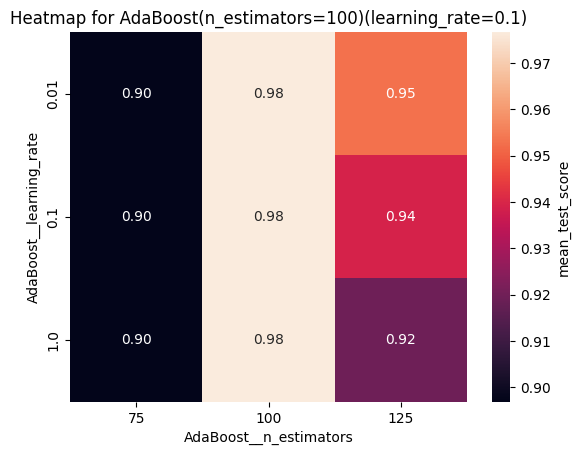

In [ ]:
path_ada2 = paths['supervised_products'] + paths['grid-searches'] + 'GS_AdaBoost(n_estimators*_2.pkl'
hg_gs_ada2 = load_grid_search(pkl_name=path_ada2)
heatmap_from_gs(hg_gs_ada2, model_name='AdaBoost')

In [98]:
print(hg_gs_ada2.best_params_)

{'AdaBoost__learning_rate': 0.1, 'AdaBoost__n_estimators': 100}


This might be pretty close to the best we can do. We'll come back if we have more time!

### Model Analysis

This section is for producing plots, comparing statistics, anything that allows us to draw comparisons and contrast between the performance of different models.

In [138]:
# Defining best supervised models
best_knn_gs = hg_gs_knn
best_knn, best_knn_str = get_model_and_model_str(best_knn_gs, model_name='kNN')

best_dt_gs = hg_gs_dt
best_dt, best_dt_str = get_model_and_model_str(best_dt_gs, model_name='DT')

best_svmc_gs = hg_gs_svmc3
best_svmc, best_svmc_str = get_model_and_model_str(best_svmc_gs, model_name='SVM-C')

best_rfc_gs = hg_gs_rfc2
best_rfc, best_rfc_str = get_model_and_model_str(best_rfc_gs, model_name='RF-C')

best_ada_gs = hg_gs_ada2
best_ada, best_ada_str = get_model_and_model_str(best_ada_gs, model_name='AdaBoost')

print(best_knn_str, best_dt_str, best_svmc_str, best_rfc_str, best_ada_str)

kNN(k=3)(algorithm=auto) DT(max_depth=8)(criterion=entropy) SVM-C(C=100000)(gamma=0.01) RF-C(n_estimators=500) AdaBoost(n_estimators=100)(learning_rate=0.1)


Let's re-run our grid searches, with each model's hyperparameters set to the values listed above. This way we can see which ones are the fastest.

In [116]:
# NOTE: THIS CODE BLOCK CORRESPONDS TO THE INITIAL/ABANDONED TIME-MEASURING METHOD
# Determining the training+testing times of each best model
X_train_scaled = StandardScaler().fit(X_train).transform(X_train)
X_test_scaled = StandardScaler().fit(X_train).transform(X_test)

#---kNN 
tstart = time.time()
knn_timed = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
knn_timed.fit(X_train_scaled, Y_train)
knn_timed.predict(X_test_scaled)
knn_time = time.time() - tstart

#---DT
tstart = time.time()
dt_timed = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=0)
dt_timed.fit(X_train, Y_train)
dt_timed.predict(X_test)
dt_time = time.time() - tstart

#---SVM-C
tstart = time.time()
svmc_timed = SVC(C=10000, gamma=0.01, kernel='rbf', random_state=0)
svmc_timed.fit(X_train_scaled, Y_train)
svmc_timed.predict(X_test_scaled)
svmc_time = time.time() - tstart

#---RF-C
tstart = time.time()
rfc_timed = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)
rfc_timed.fit(X_train, Y_train)
rfc_timed.predict(X_test)
rfc_time = time.time() - tstart

#---Adaboost
tstart = time.time()
ada_timed = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=0, estimator=DecisionTreeClassifier(max_depth=1, criterion='gini'))
ada_timed.fit(X_train, Y_train)
ada_timed.predict(X_test)
ada_time = time.time() - tstart


In [139]:
best_knn_pipe, best_knn_pg = create_knn_for_grid_search(n_neighbors=[3], algos=['auto'])
best_gs_knn, knn_time = get_grid_search_results(best_knn_pipe, best_knn_pg, save_model_to_pkl=False, save_gs_to_pkl=False)

best_dt_pipe, best_dt_pg = create_dt_for_grid_search(max_depth=[8], criterion=['entropy'])
best_gs_dt, dt_time = get_grid_search_results(best_dt_pipe, best_dt_pg, save_gs_to_pkl=False, save_model_to_pkl=False)

best_svmc_pipe, best_svmc_pg = create_svmc_for_grid_search(C=[100000], gamma=[0.01])
best_gs_svmc, svmc_time = get_grid_search_results(best_svmc_pipe, best_svmc_pg, save_model_to_pkl=False, save_gs_to_pkl=False)

best_rfc_pipe, best_rfc_pg = create_rfc_for_grid_search(n_estimators=[500])
best_gs_rfc, rfc_time = get_grid_search_results(best_rfc_pipe, best_rfc_pg, save_model_to_pkl=False, save_gs_to_pkl=False)

best_ada_pipe, best_ada_pg = create_adaboost_for_grid_search(n_estimators=[100], learning_rate=[0.1])
best_gs_ada, ada_time = get_grid_search_results(best_ada_pipe, best_ada_pg, save_model_to_pkl=False, save_gs_to_pkl=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('kNN', KNeighborsClassifier(n_neighbors=3))])
Best Parameters: {'kNN__algorithm': 'auto', 'kNN__n_neighbors': 3}
Best CV Score: 0.96624
Test Score: 0.96628
Mean Fit Time: 0.18098816871643067s
Time to complete grid search: 30.90535593032837s = 0.5150892655054728 minutes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Model: Pipeline(steps=[('DT',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        random_state=0))])
Best Parameters: {'DT__criterion': 'entropy', 'DT__max_depth': 8}
Best CV Score: 0.98296
Test Score: 0.98244
Mean Fit Time: 0.8085229873657227s
Time to complete grid search: 4.325043678283691s = 0.07208406130472819 minutes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM-C', SVC

In [141]:
# Calculating the time efficiency of each model
max_time = np.max([knn_time, dt_time, svmc_time, rfc_time, ada_time])

knn_time_norm = knn_time/max_time
knn_time_eff = 1-knn_time_norm
print('kNN time efficiency: ' + str(knn_time_eff))

dt_time_norm = dt_time/max_time
dt_time_eff = 1-dt_time_norm
print('DT time efficiency: ' + str(dt_time_eff))

svmc_time_norm = svmc_time/max_time
svmc_time_eff = 1-svmc_time_norm
print('SVM-C time efficiency: ' + str(svmc_time_eff))

rfc_time_norm = rfc_time/max_time
rfc_time_eff = 1-rfc_time_norm
print('RF-C time efficiency: ' + str(rfc_time_eff))

ada_time_norm = ada_time/max_time
ada_time_eff = 1-ada_time_norm
print('AdaBoost time efficiency: ' + str(ada_time_eff))

kNN time efficiency: 0.9684556557568925
DT time efficiency: 0.9955855332337276
SVM-C time efficiency: 0.0
RF-C time efficiency: 0.7581751483054382
AdaBoost time efficiency: 0.9644886512794193


In [121]:
# NOTE: THIS CODE BLOCK CORRESPONDS TO THE INITIAL/ABANDONED RANKING METHOD
# Calculating the spatial efficiency of each model
knn_space = 7801 #KB
dt_space = 24 #KB
svmc_space = 257 #KB
rfc_space = 81700 #KB
ada_space = 57 #KB 

max_space = np.max([knn_space, dt_space, svmc_space, rfc_space, ada_space])

knn_space_norm = knn_space/max_space
knn_space_eff = 1-knn_space_norm
print('kNN space efficiency: ' + str(knn_space_eff))

dt_space_norm = dt_space/max_space
dt_space_eff = 1-dt_space_norm
print('DT space efficiency: ' + str(dt_space_eff))

svmc_space_norm = svmc_space/max_space
svmc_space_eff = 1-svmc_space_norm
print('SVM-C space efficiency: ' + str(svmc_space_eff))

rfc_space_norm = rfc_space/max_space
rfc_space_eff = 1-rfc_space_norm
print('RF-C space efficiency: ' + str(rfc_space_eff))

ada_space_norm = ada_space/max_space
ada_space_eff = 1-ada_space_norm
print('Adaboost space efficiency: ' + str(ada_space_eff))

kNN space efficiency: 0.904516523867809
DT space efficiency: 0.9997062423500612
SVM-C space efficiency: 0.9968543451652386
RF-C space efficiency: 0.0
Adaboost space efficiency: 0.9993023255813953


In [142]:
# Defining best models' scores
knn_acc = best_gs_knn.best_score_
print('kNN accuracy: ' + str(knn_acc))

dt_acc = best_gs_dt.best_score_
print('DT accuracy: ' + str(dt_acc))

svmc_acc = best_gs_svmc.best_score_
print('SVM-C accuracy: ' + str(svmc_acc))

rfc_acc = best_gs_rfc.best_score_
print('RF-C accuracy: ' + str(rfc_acc))

ada_acc = best_gs_ada.best_score_
print('AdaBoost accuracy: ' + str(ada_acc))

kNN accuracy: 0.96624
DT accuracy: 0.98296
SVM-C accuracy: 0.98228
RF-C accuracy: 0.9857333333333334
AdaBoost accuracy: 0.9568133333333332


In [ ]:
# NOTE: THIS CODE BLOCK CORRESPONDS TO THE INITIAL/ABANDONED RANKING METHOD
# Calculating each model's points out of 30

knn_pts = (knn_time_eff*10) + (knn_space_eff*10) + (knn_acc*10)
print('kNN points: ' + str(knn_pts))
dt_pts = (dt_time_eff*10) + (dt_space_eff*10) + (dt_acc*10)
print('DT points: ' + str(dt_pts))
svmc_pts = (svmc_time_eff*10) + (svmc_space_eff*10) + (svmc_acc*10)
print('SVM-C points: ' + str(svmc_pts))
rfc_pts = (rfc_time_eff*10) + (rfc_space_eff*10) + (rfc_acc*10)
print('RF-C points: ' + str(rfc_pts))
ada_pts = (ada_time_eff*10) + (ada_space_eff*10) + (ada_acc*10)
print('AdaBoost points: ' + str(ada_pts))

In [143]:
# Calculating time-weighted accuracies
knn_tacc = (knn_acc * 0.9) + (knn_time_eff * 0.1)
print('kNN time-weighted accuracy: ' + str(knn_tacc))

dt_tacc = (dt_acc * 0.9) + (dt_time_eff * 0.1)
print('DT time-weighted accuracy: ' + str(dt_tacc))

svmc_tacc = (svmc_acc * 0.9) + (svmc_time_eff * 0.1)
print('SVM-C time-weighted accuracy: ' + str(svmc_tacc))

rfc_tacc = (rfc_acc * 0.9) + (rfc_time_eff * 0.1)
print('RF-C time-weighted accuracy: ' + str(rfc_tacc))

ada_tacc = (ada_acc * 0.9) + (ada_time_eff * 0.1)
print('Adaboost time-weighted accuracy: ' + str(ada_tacc))



kNN time-weighted accuracy: 0.9664615655756893
DT time-weighted accuracy: 0.9842225533233728
SVM-C time-weighted accuracy: 0.8840520000000001
RF-C time-weighted accuracy: 0.962977514830544
Adaboost time-weighted accuracy: 0.9575808651279418


To have a nuanced understanding of each model's performance, we plotted a confusion matrix for each algorithm.

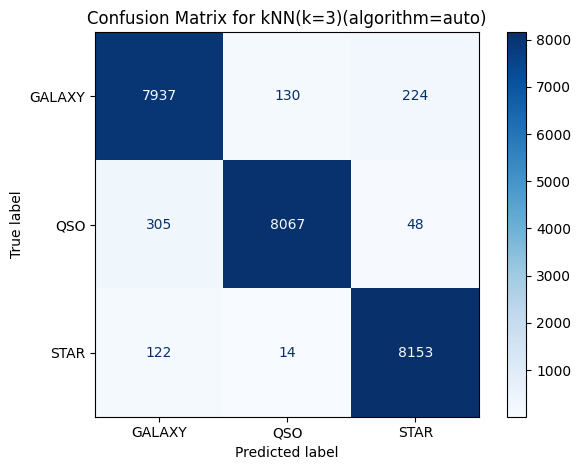

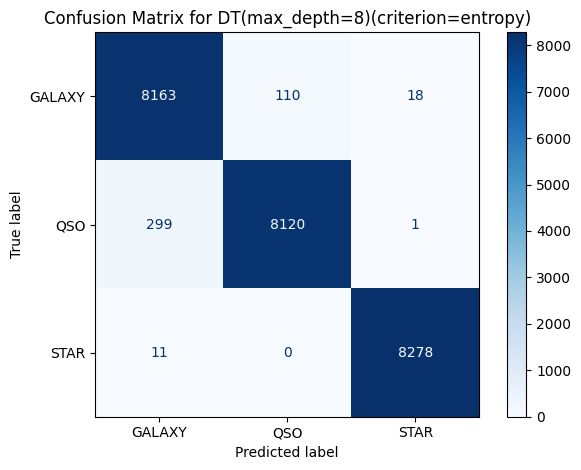

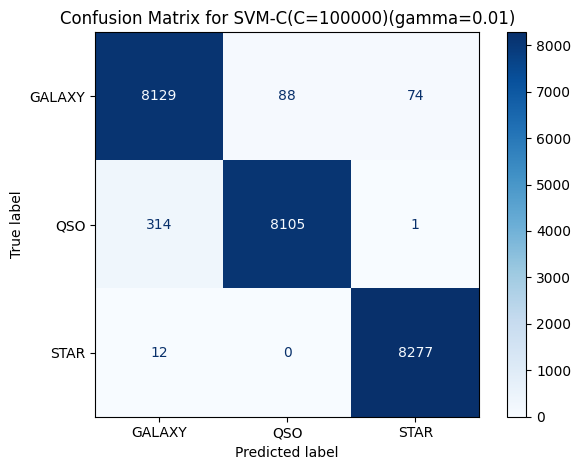

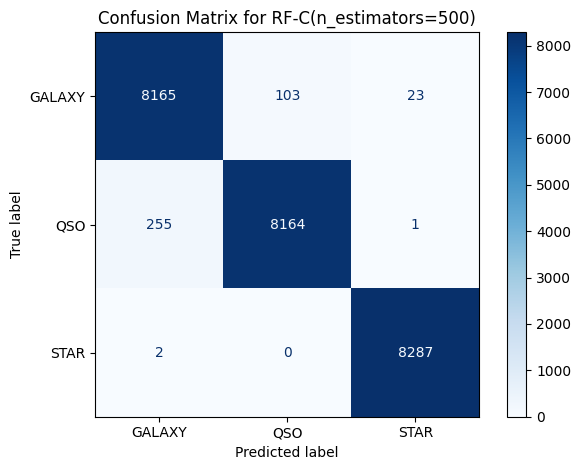

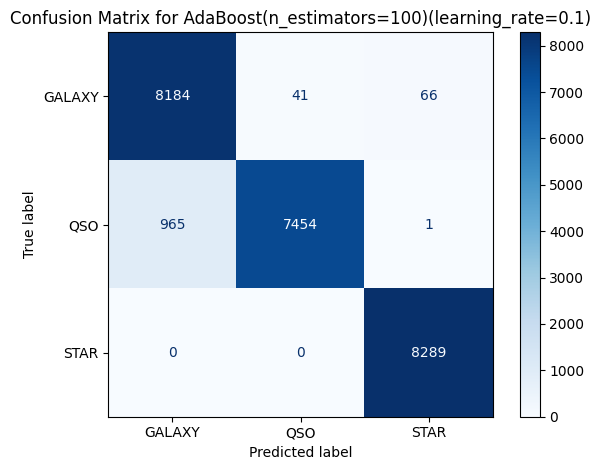

In [160]:
confusion_matrix_from_grid_search(best_gs_knn, model_name='kNN')
confusion_matrix_from_grid_search(best_gs_dt, model_name='DT')
confusion_matrix_from_grid_search(best_gs_svmc, model_name='SVM-C')
confusion_matrix_from_grid_search(best_gs_rfc, model_name='RF-C')
confusion_matrix_from_grid_search(best_gs_ada, model_name='AdaBoost')

## Unsupervised Machine Learning

### NOTE: THIS SECTION IS NOW IGNORED

This section contains training, optimization, testing, and creation of products for the following unsupervised machine learning algorithms:

- k-Means Clustering (k-means)
- Gaussian Mixture Model (GMM) Clustering
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN), using kNN for epsilon determination


### Training Setup

In [ ]:
# Produce a pipeline and parameter grid for kMeans
def create_kmeans_for_grid_search(n_clusters=[len(CLASSES)], n_init=[10]):
    pipe = Pipeline([
        ('scaler', SCALER), # k-Means requires feature scaling!
        ('k-means', KMeans(random_state=0))
    ])

    param_grid = {
        'k-means__n_clusters': n_clusters,
        'k-means__n_init': n_init
    }

    return pipe, param_grid

In [ ]:
# Produce a pipeline and parameter grid for GMM
def create_gmm_for_grid_search(n_components=[len(CLASSES)], n_init=[10]):
    pipe = Pipeline([
        ('scaler', SCALER), # GMM requires feature scaling!
        ('GMM', GaussianMixture(random_state=0))
    ])

    param_grid = {
        'GMM__n_components': n_components,
        'GMM__n_init': n_init
    }
    
    return pipe, param_grid

In [ ]:
# DBSCAN nearest neighbors for epsilon estimation - Adadpted from Module 6 Clustering Worksheet
def plot_dbscan_nearest_neighbors(n_neighbors=5, x_tr=X_train, save=True):
    dbs_nn = NearestNeighbors(n_neighbors=n_neighbors)
    dbs_neighbors = dbs_nn.fit(x_tr)
    dbs_distances, dbs_indices = dbs_neighbors.kneighbors(x_tr)

    dbs_distances = dbs_distances[:,-1]
    dbs_distances = np.sort(dbs_distances, axis=0)
    plt.plot(dbs_distances, '.')
    plt.title(f'Distance to the {n_neighbors}th nearest neighbor for {len(x_tr)} rows')
    plt.ylabel("Distance")
    plt.xlabel("Index")
    if save: plt.savefig(paths['unsupervised_products'] + paths['graphs'] + f'Nearest_Neighbors_DBSCAN(n_neighbors={n_neighbors})(rows={len(x_tr)}).png', dpi=300)

# Produce a pipeline and parameter grid for DBSCAN
def create_dbscan_for_grid_search(eps=np.arange(0, 1, 0.1), min_samples=np.arange(5, 16)):
    pipe = Pipeline([
        ('scaler', SCALER), # DBSCAN requires feature scaling!
        ('DBSCAN', DBSCAN())
    ])

    param_grid = {
        'DBSCAN__eps': eps,
        'DBSCAN__min_samples': min_samples
    }

    return pipe, param_grid

### Analysis Setup

### Model Training

The following training runs were performed on HiperGator, and the resulting `grid_search` objects were saved and loaded locally for analysis and improved training runs.

In [ ]:
# RUN ON HIPERGATOR
# pipe_kmeans, pg_kmeans = create_kmeans_for_grid_search()
# gs_kmeans = get_grid_search_results(pipe=pipe_kmeans, param_grid=pg_kmeans, unsupervised=True)

In [ ]:
# RUN ON HIPERGATOR
# pipe_gmm, pg_gmm = create_gmm_for_grid_search()
# gs_gmm = get_grid_search_results(pipe=pipe_gmm, param_grid=pg_gmm, unsupervised=True)

For DBSCAN, we'll run an `sklearn.neighbors.NearestNeighbors` learner and plot the results to see where the epsilon value could be. This part is run locally and defaults to `n_neighbors=5`. 

In [ ]:
# RUN LOCALLY
plot_dbscan_nearest_neighbors()

Hmm. This is a lot of data. We use the y-axis as our basis of estimation, and its difficult to read - perhaps we need to try something different. Let's reduce the size of the data by a factor of $10$, just for this graph.

In [ ]:
# RUN LOCALLY
plot_dbscan_nearest_neighbors(x_tr=X_train[::10])

This is a bit more legible! We'll start with `eps=[1.3, 1.4, 1.5]`, and the default for `min_samples`, set to `np.arange(5, 16)`.

In [ ]:
# RUN ON HIPERGATOR
# pipe_dbscan, pg_dbscan = create_dbscan_for_grid_search(eps=[1.3, 1.4, 1.5])
# gs_dbscan = get_grid_search_results(pipe=pipe_dbscan, param_grid=pg_dbscan, unsupervised=True)

### Model Analysis and Optimization

#### k-Means

Loading file ./products/unsupervised/grid-searches/GS_k-means(n_clusters=3)(n_init=10).pkl for pkl_name=./products/unsupervised/grid-searches/GS_k-means*.pkl


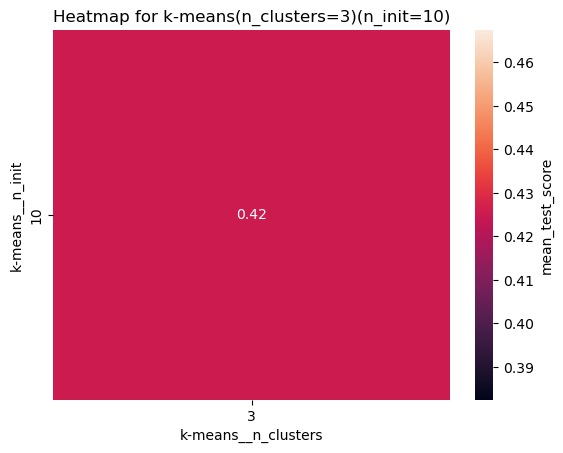

In [98]:
# DOWNLOADED FROM HIPERGATOR
path_kmeans = paths['unsupervised_products'] + paths['grid-searches'] + 'GS_k-means*.pkl'
hg_gs_kmeans = load_grid_search(pkl_name=path_kmeans)
heatmap_from_gs(hg_gs_kmeans, model_name='k-means')

#### GMM

Loading file ./products/unsupervised/grid-searches/GS_GMM(n_components=3)(n_init=10).pkl for pkl_name=./products/unsupervised/grid-searches/GS_GMM*.pkl


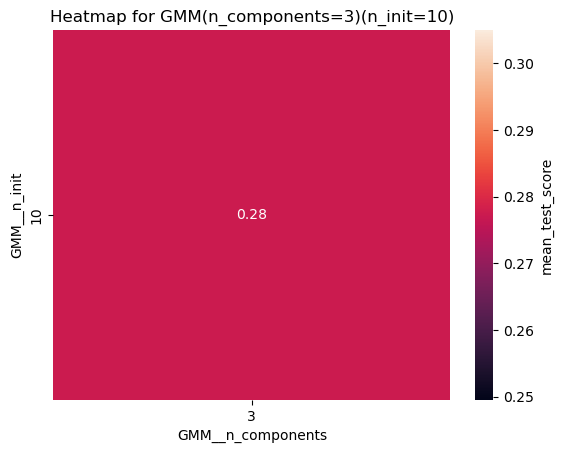

In [100]:
# DOWNLOADED FROM HIPERGATOR
path_gmm = paths['unsupervised_products'] + paths['grid-searches'] + 'GS_GMM*.pkl'
hg_gs_gmm = load_grid_search(pkl_name=path_gmm)
heatmap_from_gs(hg_gs_gmm, model_name='GMM')

#### DBSCAN

In [101]:
# DOWNLOADED FROM HIPERGATOR
path_dbscan = paths['unsupervised_products'] + paths['grid-searches'] + 'GS_DBSCAN*.pkl'
hg_gs_dbscan = load_grid_search(pkl_name=path_dbscan)
heatmap_from_gs(hg_gs_dbscan, model_name='DBSCAN')

IndexError: list index out of range

#### Neural Network......?